# 1. Pre-steps
Including importing packages, login to the NASA Earthdata system, and get the token needed. Before you start, make sure you have registered an account in NASA Earthdata website: https://lpdaacsvc.cr.usgs.gov/appeears/

In [1]:
import requests as r
import getpass, pprint, time, os, cgi, json
import geopandas as gpd

# Enter Earth Data login Credentials
username = "ZekunLin"#getpass.getpass('Earthdata Username:')
password = "P6Fn8T47"#getpass.getpass('Earthdata Password:')

api = 'https://lpdaacsvc.cr.usgs.gov/appeears/api/'  # Set the AρρEEARS API to a variable

token_response = r.post('{}login'.format(api), auth=(username, password)).json() # Insert API URL, call login service, provide credentials & return json
del username, password                                                           # Remove user and password information
token_response 

{'token_type': 'Bearer',
 'token': '88PnUG1LL3FzkXK0FdCuFXwBC_M9D1_Jfz_D71yfAINqjdoT6iX-DnbHR-ZhM9eiazWsoZH59G0YlzYDuO5v-Q',
 'expiration': '2020-10-25T02:26:52Z'}

# 2. Query available products
This section includes search available products and their layers. The most important thing in this section is to format the variable that stores products and layers we need. We will store this information in a variable named `prodLayer`, if you already know which product and layer to use, just formant the `prodLayer` variable as the example below.
## 2a. Search and explore available products

In [3]:
product_response = r.get('{}product'.format(api)).json()                         # request all products in the product service
print('AρρEEARS currently supports {} products.'.format(len(product_response)))  # Print no. products available in AppEEARS


AρρEEARS currently supports 120 products.


An example of a product's format in json:

In [4]:
products = {p['ProductAndVersion']: p for p in product_response} # Create a dictionary indexed by product name & version
products['CU_LT05.001']                                         # Print information for MCD15A3H.006 LAI/FPAR Product

ailable': True, 'DocLink': 'https://doi.org/10.5067/ASTER/ASTWBD_NC.001', 'Source': 'LP DAAC', 'TemporalExtentStart': '2000-03-01', 'TemporalExtentEnd': '2000-03-01', 'Deleted': False, 'DOI': '10.5067/ASTER/ASTWBD_NC.001', 'ProductAndVersion': 'ASTWBD_NC.001'}, 'VNP09H1.001': {'Product': 'VNP09H1', 'Platform': 'S-NPP NASA VIIRS', 'Description': 'Surface Reflectance', 'RasterType': 'Tile', 'Resolution': '500m', 'TemporalGranularity': '8 day', 'Version': '001', 'Available': True, 'DocLink': 'https://doi.org/10.5067/viirs/vnp09h1.001', 'Source': 'LP DAAC', 'TemporalExtentStart': '2012-01-17', 'TemporalExtentEnd': 'Present', 'Deleted': False, 'DOI': '10.5067/VIIRS/VNP09H1.001', 'ProductAndVersion': 'VNP09H1.001'}, 'VNP09A1.001': {'Product': 'VNP09A1', 'Platform': 'S-NPP NASA VIIRS', 'Description': 'Surface Reflectance', 'RasterType': 'Tile', 'Resolution': '1000m', 'TemporalGranularity': '8 day', 'Version': '001', 'Available': True, 'DocLink': 'https://doi.org/10.5067/viirs/vnp09a1.001', 'S

{'Product': 'CU_LT05',
 'Platform': 'Landsat ARD',
 'Description': 'Landsat 5 Surface Reflectance',
 'RasterType': 'Tile',
 'Resolution': '30m',
 'TemporalGranularity': '16 day',
 'Version': '001',
 'Available': True,
 'DocLink': 'https://www.usgs.gov/land-resources/nli/landsat/us-landsat-analysis-ready-data',
 'Source': 'USGS',
 'TemporalExtentStart': '1984-01-01',
 'TemporalExtentEnd': '2013-12-31',
 'Deleted': False,
 'DOI': '10.3390/rs10091363',
 'ProductAndVersion': 'CU_LT05.001'}

We can search for specific products using keywords or strings. For example, here we search for products containing "Leaf Area Index" in the `Description`.

In [6]:
prodNames = {p['ProductAndVersion'] for p in product_response}
for p in prodNames:
    if "Landsat" in products[p]["Description"]:
        pprint.pprint(products[p])

{'Available': True,
 'DOI': '10.3390/rs10091363',
 'Deleted': False,
 'Description': 'Alaska Landsat 7 Surface Reflectance',
 'DocLink': 'https://www.usgs.gov/land-resources/nli/landsat/us-landsat-analysis-ready-data',
 'Platform': 'Landsat ARD',
 'Product': 'AK_LE07',
 'ProductAndVersion': 'AK_LE07.001',
 'RasterType': 'Tile',
 'Resolution': '30m',
 'Source': 'USGS',
 'TemporalExtentEnd': 'Present',
 'TemporalExtentStart': '1999-01-01',
 'TemporalGranularity': '16 day',
 'Version': '001'}
{'Available': True,
 'DOI': '10.3390/rs10091363',
 'Deleted': False,
 'Description': 'Alaska Landsat 5 Surface Reflectance',
 'DocLink': 'https://www.usgs.gov/land-resources/nli/landsat/us-landsat-analysis-ready-data',
 'Platform': 'Landsat ARD',
 'Product': 'AK_LT05',
 'ProductAndVersion': 'AK_LT05.001',
 'RasterType': 'Tile',
 'Resolution': '30m',
 'Source': 'USGS',
 'TemporalExtentEnd': '2013-12-31',
 'TemporalExtentStart': '1984-01-01',
 'TemporalGranularity': '16 day',
 'Version': '001'}
{'Avail

Now, using the above information, we can format the variable containing products we need. For example, here we select "MCD15A3H.006", "MOD11A2.006", and "SRTMGL1_NC.003":

In [16]:
prods = ["CU_LT05.001"]
print(prods)

['CU_LT05.001']


## 2b. Search and explore available layers
Next step is to get the layers we want from those products. We start from searching their all available layers.

In [17]:
srb_response = r.get("{}product/{}".format(api, prods[0])).json()

list(srb_response.keys())

['LINEAGEQA',
 'PIXELQA',
 'RADSATQA',
 'SRATMOSOPACITYQA',
 'SRB1',
 'SRB2',
 'SRB3',
 'SRB4',
 'SRB5',
 'SRB7',
 'SRCLOUDQA']

If you want to check the information in a specific layer, you can do:

In [18]:
srb_response["SRB1"]

{'AddOffset': 0.0,
 'Available': True,
 'DataType': 'int16',
 'Description': 'band 1 surface reflectance',
 'Dimensions': ['time', 'YDim', 'XDim'],
 'FillValue': -9999.0,
 'IsQA': False,
 'Layer': 'SRB1',
 'OrigDataType': 'int16',
 'OrigValidMax': 16000,
 'OrigValidMin': -2000,
 'QualityLayers': "['PIXELQA']",
 'QualityProductAndVersion': 'CU_LT05.001',
 'ScaleFactor': 0.0001,
 'Units': 'reflectance',
 'ValidMax': 16000,
 'ValidMin': -2000,
 'XSize': 5000,
 'YSize': 5000}

Now, say we want 2 layers from this product: "LST_Day_1km" and "LST_Night_1km", we can do:

In [19]:
layers = [(prods[0], "PIXELQA"), (prods[0], "SRB1"), (prods[0], "SRB2"), (prods[0], "SRB3"), (prods[0], "SRB4"), (prods[0], "SRB5"), (prods[0], "SRB7"), (prods[0], "SRCLOUDQA")]
print((prods[0]), "SRB1")

CU_LT05.001 SRB1


Note: it is not required to store the product and layer information in a tupled list, but doing so wll make formatting json request later convinient.

We can use the same method to explore other products and their layers, now let's suppose we already done that and we got a tupled list that contains all products and layers we want:

In [20]:
layers

[('CU_LT05.001', 'PIXELQA'),
 ('CU_LT05.001', 'SRB1'),
 ('CU_LT05.001', 'SRB2'),
 ('CU_LT05.001', 'SRB3'),
 ('CU_LT05.001', 'SRB4'),
 ('CU_LT05.001', 'SRB5'),
 ('CU_LT05.001', 'SRB7'),
 ('CU_LT05.001', 'SRCLOUDQA')]

THen we can format this tupled list to a json variable, we store them in the variable `prodLayer` we mentioned earlier in this document.

In [21]:
prodLayer = []
for l in layers:
    prodLayer.append({
        "layer": l[1],
        "product": l[0]
    })
prodLayer

[{'layer': 'PIXELQA', 'product': 'CU_LT05.001'},
 {'layer': 'SRB1', 'product': 'CU_LT05.001'},
 {'layer': 'SRB2', 'product': 'CU_LT05.001'},
 {'layer': 'SRB3', 'product': 'CU_LT05.001'},
 {'layer': 'SRB4', 'product': 'CU_LT05.001'},
 {'layer': 'SRB5', 'product': 'CU_LT05.001'},
 {'layer': 'SRB7', 'product': 'CU_LT05.001'},
 {'layer': 'SRCLOUDQA', 'product': 'CU_LT05.001'}]

# 3. Submit an "Area Request"
Now we have the products and layers we need, but before submitting the job to AppEEARS application, we need a region indicating our area of interest and a time period indicating the what are the time series we want.

## 3a. import a shapefile
Let's import a shapefile first, and subset the shapefile to the area of interest only, and convert it to json format.

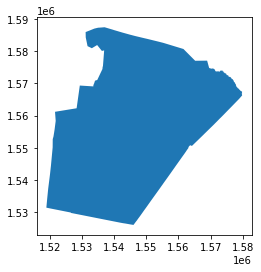

In [22]:
nps = gpd.read_file("D:\Zekun\Landsat_ARD\Landsat_ARD\wake_shp\wake.shp")
nps.crs
ax = nps.plot()
nps = nps.to_crs("EPSG:4326")
nps_gc = nps[nps["NAME"] == "Wake"].to_json()
nps_gc = json.loads(nps_gc)


## 3b. Search and explore available projections

In [23]:
projections = r.get('{}spatial/proj'.format(api)).json()  # Call to spatial API, return projs as json
projections

[{'Name': 'native',
  'Description': 'Native Projection',
  'Platforms': '',
  'Proj4': '',
  'Datum': '',
  'EPSG': '',
  'Units': '',
  'GridMapping': '',
  'Available': True},
 {'Name': 'geographic',
  'Description': 'Geographic',
  'Platforms': "['SRTM', 'ECOSTRESS', 'SSEBop ET', 'GPW', 'ASTER GDEM', 'NASADEM']",
  'Proj4': '+proj=longlat +datum=WGS84 +no_defs',
  'Datum': 'wgs84',
  'EPSG': 4326.0,
  'Units': 'degrees',
  'GridMapping': 'latitude_longitude',
  'Available': True},
 {'Name': 'sinu_modis',
  'Description': 'MODIS Sinusoidal',
  'Platforms': "['Combined MODIS', 'Terra MODIS', 'Aqua MODIS', 'S-NPP NASA VIIRS', 'Global WELD']",
  'Proj4': '+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs',
  'Datum': '',
  'EPSG': '',
  'Units': 'meters',
  'GridMapping': 'sinusoidal',
  'Available': True},
 {'Name': 'albers_weld_alaska',
  'Description': 'WELD Albers Equal Area Alaska',
  'Platforms': "['WELD']",
  'Proj4': '+proj=aea +lat_1=55 +lat_2=6

Let's store all projection names in a variable:

In [24]:
projs = {}
for p in projections:
    projs[p["Name"]] = p
list(projs.keys())

['native',
 'geographic',
 'sinu_modis',
 'albers_weld_alaska',
 'albers_weld_conus',
 'albers_ard_alaska',
 'albers_ard_conus',
 'albers_ard_hawaii',
 'easegrid_2_global',
 'easegrid_2_north',
 'laea_sphere_19']

Say we want to use the projection "geographic" here:

In [25]:
projs["albers_ard_conus"]

{'Name': 'albers_ard_conus',
 'Description': 'Landsat ARD Albers Equal Area CONUS',
 'Platforms': "['Landsat ARD']",
 'Proj4': '+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs',
 'Datum': 'wgs84',
 'EPSG': '',
 'Units': 'meters',
 'GridMapping': 'albers_conical_equal_area',
 'Available': True}

## 3c. Compile a json and submit the task request
OK, now we are ready to go. To submit a task request, we need to format the variables in json format and submit it to the AppEEARS system

In [26]:
# task_name = input("Enter a Task Name:")
task_name = "test_1"
task_type = ["point", "area"]
proj = projs["geographic"]["Name"]
outFormat = ["geotiff"]

startDate = "01-01-2010"
endDate = "01-31-2010"

recurring = False

# format them into a json variable
task = {
    "task_type": task_type[1], # area sample task
    "task_name": task_name,
    "params": {
        "dates": [
        {
            "startDate": startDate,
            "endDate": endDate
        }],
        "layers": prodLayer,
        "output": {
            "format": {
                "type": outFormat[0] # geotiff format
            },
            "projection": proj
        },
        "geo": nps_gc
    }
}

To submit the task, we only need to post this json variable to AppEEARS api address:

In [5]:
token = token_response['token']                      # Save login token to a variable
head = {'Authorization': 'Bearer {}'.format(token)}  # Create a header to store token information, needed to submit a request

task_response = r.post("{}task".format(api), json = task, headers = head).json()
task_response

NameError: name 'task' is not defined

Now the task has been submitted, once it is done, we can download the result. Actually, once the task has been sumitted successfully, you will receive a notification email. Also, you can check the task status by login to the website of AppEEARS or using a retrieve script as below:

In [3]:
task_id = "a7a6091d-e0e3-4112-8567-904fc89b493d"  #task_response['task_id']                                               # Set task id from request submission
status_response = r.get('{}status/{}'.format(api, task_id), headers=head).json() # Call status service with specific task ID & user credentials
status_response['status']

NameError: name 'head' is not defined

# 4. Download a request
At this step, the task we submitted has completed, we need to download the resutls. But first, we must know which files to download:

In [6]:
task_id = 'a7a6091d-e0e3-4112-8567-904fc89b493d'
bundle = r.get('{}bundle/{}'.format(api,task_id)).json()  # Call API and return bundle contents for the task_id as json
bundle

1_2010351_to_2015365/CU_LE07.001_SRB5_doy2011057_aid0001.tif',
   'file_size': 5135177,
   'file_type': 'tif'},
  {'sha256': 'd92d2d51e8cb87b49e25f2ba62ce98e01c1ee4a0d9d1c260690126d53a6e7319',
   'file_id': '497fa12e-7b0b-48f4-8100-9fadf9ad57a1',
   'file_name': 'CU_LE07.001_2010351_to_2015365/CU_LE07.001_SRB5_doy2011066_aid0001.tif',
   'file_size': 4247963,
   'file_type': 'tif'},
  {'sha256': '8746c48857d9a0194c2455e27d676b01a69fd8ed348135338b1cac86fbe72449',
   'file_id': '50f8158f-66f7-4170-84cc-da651779fcae',
   'file_name': 'CU_LE07.001_2010351_to_2015365/CU_LE07.001_SRB5_doy2011073_aid0001.tif',
   'file_size': 3780285,
   'file_type': 'tif'},
  {'sha256': '33e09d9e2e1312ab34ae4b2290b7d805537dd6f5ee54db8f60186526372aac08',
   'file_id': '27fd428a-638d-4dc6-a61a-8f72e88e477b',
   'file_name': 'CU_LE07.001_2010351_to_2015365/CU_LE07.001_SRB5_doy2011082_aid0001.tif',
   'file_size': 4169568,
   'file_type': 'tif'},
  {'sha256': 'b2b7d0e4c6aa0a54ae9d10a2d9da38141c6a65e1ea578c4f4b97

Store those files to a variable:

In [7]:
files = {}                                                       # Create empty dictionary
for f in bundle['files']: files[f['file_id']] = f['file_name']   # Fill dictionary with file_id as keys and file_name as values
files

-440b-a041-c97441756523': 'CU_LE07.001_2010351_to_2015365/CU_LE07.001_SRB4_doy2013110_aid0001.tif',
 '3cde7861-72cf-4320-8935-4407415b4dd2': 'CU_LE07.001_2010351_to_2015365/CU_LE07.001_SRB4_doy2013135_aid0001.tif',
 '8f4a5cd6-3f11-4050-a963-0d5e9579dcb5': 'CU_LE07.001_2010351_to_2015365/CU_LE07.001_SRB4_doy2013142_aid0001.tif',
 'a751da94-78fb-4258-aa2e-ef05442702fb': 'CU_LE07.001_2010351_to_2015365/CU_LE07.001_SRB4_doy2013151_aid0001.tif',
 '47f2ee22-bd56-4b38-8034-b23baa8ba3b2': 'CU_LE07.001_2010351_to_2015365/CU_LE07.001_SRB4_doy2013167_aid0001.tif',
 '3d720a88-9820-47dc-ab59-531d348a0603': 'CU_LE07.001_2010351_to_2015365/CU_LE07.001_SRB4_doy2013174_aid0001.tif',
 '2be35497-8adf-4cde-9c90-a90968e12dfc': 'CU_LE07.001_2010351_to_2015365/CU_LE07.001_SRB4_doy2013183_aid0001.tif',
 '9fcfc158-e4a1-46d3-9006-43c253e52f0b': 'CU_LE07.001_2010351_to_2015365/CU_LE07.001_SRB4_doy2013199_aid0001.tif',
 '9985895f-74c8-4918-ba39-dac3846056a3': 'CU_LE07.001_2010351_to_2015365/CU_LE07.001_SRB4_doy20

Then, just download to wherever you want:

In [8]:
destDir = os.path.join("D:\Zekun\landsat_ard_data\wake_ard_period4")#, #task_name)
if not os.path.exists(destDir) : os.makedirs(destDir)

for f in files:
    dl = r.get('{}bundle/{}/{}'.format(api, task_id, f), stream=True)                                # Get a stream to the bundle file
    filename = os.path.basename(cgi.parse_header(dl.headers['Content-Disposition'])[1]['filename'])  # Parse the name from Content-Disposition header 
    filepath = os.path.join(destDir, filename)                                                       # Create output file path
    with open(filepath, 'wb') as f:                                                                  # Write file to dest dir
        for data in dl.iter_content(chunk_size=8192): f.write(data) 
print('Downloaded files can be found at: {}'.format(destDir))

Downloaded files can be found at: D:\Zekun\landsat_ard_data\wake_ard_period4
